[('HG00514', 'CLR'), ('HG00514', 'HiFi'), ('HG02011', 'CLR'), ('HG02492', 'CLR'), ('HG03371', 'CLR'), ('HG03683', 'CLR'), ('NA12329', 'CLR')]
---------------


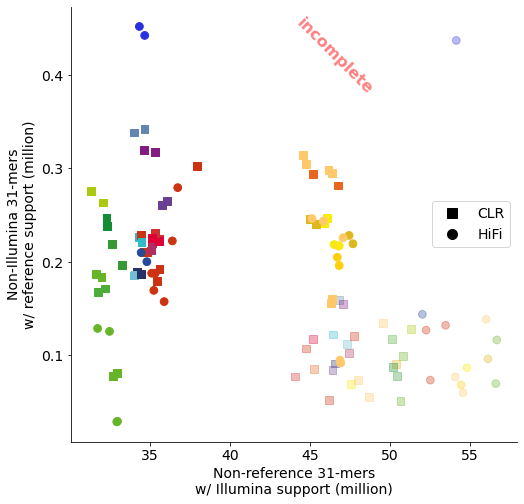

In [24]:
import os
import collections as col
import importlib
import operator
import math

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines

plot_aux_module = '/home/local/work/code/github/project-diploid-assembly/notebooks/aux_mods/plot_aux.py'
plot_aux_spec = importlib.util.spec_from_file_location("plot_aux", plot_aux_module)
plot_aux = importlib.util.module_from_spec(plot_aux_spec)
plot_aux_spec.loader.exec_module(plot_aux)

samples = plot_aux.load_sample_table()
hexcodes, rgbcodes, popmap = plot_aux.load_population_annotation()

prop = plot_aux.get_plot_property

pipeline_version = 'v12'

stats_path = '/home/local/work/data/hgsvc/fig1_panels/kmer_stats'
out_path = os.path.join(stats_path, pipeline_version, 'fig1_panel_kmer-stats')
cache_file = os.path.join(stats_path, 'cache_{}.h5'.format(pipeline_version))

keep_combinations = {
    '0': 'Illumina_only',
    '1': 'Illumina_only',
    '0-1': 'Illumina_only',
    '2': 'Hap1_only',
    '3': 'Hap2_only',
    '2-3': 'Hap_only',
    '0-2-3': 'Hap_Illumina',
    '1-2-3': 'Hap_Illumina',
    '0-1-2-3': 'Hap_Illumina',
    '0-2': 'Hap1_Illumina',
    '1-2': 'Hap1_Illumina',
    '0-1-2': 'Hap1_Illumina',
    '0-3': 'Hap2_Illumina',
    '1-3': 'Hap2_Illumina',
    '0-1-3': 'Hap2_Illumina',
    '2-4': 'Hap1_GRCh38',
    '3-4': 'Hap2_GRCh38',
    '4': 'GRCh38',
    '2-3-4': 'Hap_GRCh38',
    '0-4': 'GRCh38_Illumina',
    '1-4': 'GRCh38_Illumina',
    '0-1-4': 'GRCh38_Illumina',
}


def load_kmer_stats(file_path):
    kmer_stats = col.Counter()
    with open(file_path, 'r') as table:
        for line in table:
            if line.startswith('color'):
                continue
            _, combination, count = line.strip().split()
            if '5' in combination:
                # ignore all kmers that may be mitochondrial
                continue
            try:
                key = keep_combinations[combination]
            except KeyError:
                key = 'GRCh38_shared'
            kmer_stats[key] += int(count)
    return kmer_stats


def extract_assembly_type(file_name):
    assmt = None
    if '_nhr-' in file_name:
        assmt = 'NHR', 0
    elif 'h1-un' in file_name:
        assmt = 'HAP', 1
    elif 'h2-un' in file_name:
        assmt = 'HAP', 2
    else:
        raise ValueError('ASSMT: {}'.format(file_name))
    if assmt is None:
        raise ValueError('ASSMT: {}'.format(file_name))
    return assmt


if not os.path.isfile(cache_file):
    stat_files = plot_aux.load_plot_data_files(
        stats_path,
        '.kmer-counts.tsv',
        pipeline_version)
    plot_data = [load_kmer_stats(fp) for fp in stat_files]

    sample_platform = [
        plot_aux.extract_sample_platform(
            os.path.basename(f),
            multi_readset=True,
        ) for f in stat_files
    ]

    row_index = []
    for (sample, platform) in sample_platform:
        super_pop = samples[sample]['super_population']
        pop = samples[sample]['population']
        row_index.append((sample, super_pop, pop, platform, 'HAP', 0))

    df = pd.DataFrame(
        plot_data,
        columns=sorted(plot_data[0].keys()),
        index=row_index
    )

    df.index = pd.MultiIndex.from_tuples(
        df.index.values,
        names=['sample', 'super_pop', 'pop', 'platform', 'assembly', 'hap']
    )
    df.to_hdf(cache_file, key='cache', mode='w', format='fixed')
    
df = pd.read_hdf(cache_file, 'cache')
df.sort_index(axis=0, inplace=True, level=['sample', 'super_pop', 'pop', 'platform', 'assembly', 'hap'])        

errors, missing = plot_aux.check_cache_consistency(df)
if errors:
    raise ValueErrors('Skip sample(s) in cache: {}'.format(errors))
if missing:
    print(sorted(missing))
    print('---------------')
  
    
def plot_kmer_stats(sample_stats):
    
    fig, axis = plt.subplots(figsize=(8,8))
    
    xya_pairs = [
        ('Hap_Illumina', 'Hap_GRCh38', 0.33),
        ('Hap1_Illumina', 'Hap1_GRCh38', 1),
        ('Hap2_Illumina', 'Hap2_GRCh38', 1)
    ]

    for platform in plot_aux.get_sequencing_platforms():
        subset = sample_stats.xs(platform, level='platform', drop_level=False)
        for x, y, alpha in xya_pairs:
            x_values = subset[x].values.astype('float32')
            x_values /= 1e6
            y_values = subset[y].values.astype('float32')
            y_values /= 1e6
            colors = [rgbcodes[i] for i in subset.index.get_level_values('pop')]
            labels = [s + '-{}-{}'.format(platform, x.split('_')[0]) for s in subset.index.get_level_values('sample')]
            
            axis.scatter(
                x_values,
                y_values,
                s=prop('plot_marker_size'),
                c=colors,
                marker=prop('{}_marker'.format(platform)),
                label=labels,
                alpha=alpha
            )

    axis.set_xlabel(
        'Non-reference 31-mers\nw/ Illumina support (million)',
        fontsize=prop('fontsize_legend')
    )
    axis.set_ylabel(
        'Non-Illumina 31-mers\nw/ reference support (million)',
        fontsize=prop('fontsize_legend')
    )
    
    axis.tick_params(
        axis='both',
        which='major',
        labelsize=prop('fontsize_axis_ticks')
    )
    
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    
    # build custom legend
    custom_lines = [
        lines.Line2D(
            [0], [0],
            color='black',
            markersize=prop('legend_marker_size'),
            marker=prop('CLR_marker'),
            ls='None',
            label='CLR'
        ),
        lines.Line2D(
            [0], [0],
            color='black',
            markersize=prop('legend_marker_size'),
            marker=prop('HiFi_marker'),
            ls='None',
            label='HiFi'
        )   
    ]
    
    axis.legend(
        handles=custom_lines,
        loc='center right',
        prop={'size': prop('fontsize_legend')}
    )

    if missing:
        plot_aux.add_incomplete_stamp(axis, 0.5, 0.8)
    
    extra_artists = []

    return fig, extra_artists
        
fig, exart = plot_kmer_stats(df)
    
fig.savefig(out_path + '.png', dpi=600, bbox_inches='tight', extra_artists=exart)
fig.savefig(out_path + '.svg', bbox_inches='tight', extra_artists=exart)
        
